In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

S0 = {
    'aapl': 277.60,
    'nvda': 180.23,
    'tsla': 446.31
}

T = 8/365
r = 0.0413

STOCK = 'nvda'

In [2]:
def phi(alpha, xk, pk, f):
  return f(xk+alpha*pk)

def dphi(alpha, xk, pk, df, scaler):
  if scaler:
    return df(xk+alpha*pk)*pk
  return df(xk+alpha*pk)@pk

def zoom(alpha_low, alpha_high, xk, pk, f, df, c1, c2, scaler):
  while True:
    alpha = (alpha_low+alpha_high)/2
    if (phi(alpha,xk,pk,f) > phi(0,xk,pk,f)+c1*alpha*dphi(0,xk,pk,df,scaler)) or \
     (phi(alpha,xk,pk,f) >= phi(alpha_low,xk,pk,f)):
      alpha_high = alpha
    else:
      if (abs(dphi(alpha,xk,pk,df,scaler)) <= c2*abs(dphi(0,xk,pk,df,scaler))):
        return alpha
      if (dphi(alpha,xk,pk,df,scaler)*(alpha_high-alpha_low) >= 0):
        alpha_high = alpha_low
      alpha_low = alpha

def get_strong_wolf_alpha(xk, pk, f, df, c1=0.001, c2=0.9, alpha_max=1.0, scaler=True):
  alpha_prev = 0
  alpha = (alpha_max+alpha_prev)/2
  i = 1
  while True:
    if (phi(alpha,xk,pk,f) > phi(0,xk,pk,f)+c1*alpha*dphi(0,xk,pk,df,scaler)) or \
     (i > 1 and phi(alpha,xk,pk,f) >= phi(alpha_prev,xk,pk,f)):
      return zoom(alpha_prev,alpha,xk,pk,f,df,c1,c2,scaler)
    if (abs(dphi(alpha,xk,pk,df,scaler)) <= c2*abs(dphi(0,xk,pk,df,scaler))):
      return alpha
    if dphi(alpha,xk,pk,df,scaler) >= 0:
      return zoom(alpha_prev,alpha,xk,pk,f,df,c1,c2,scaler)
    i += 1
    alpha_prev = alpha
    alpha = (alpha+alpha_max)/2

In [3]:
def d1(vol, K):
    return (np.log(S0[STOCK]/K)+(r+0.5*vol**2)*T)/(vol*np.sqrt(T))

def d2(vol, K):
    return d1(vol,K)-vol*np.sqrt(T)

def cbs(vol, K):
    return S0[STOCK]*norm.cdf(d1(vol,K))-K*np.exp(-r*T)*norm.cdf(d2(vol,K))

def vega(vol, K):
    return S0[STOCK]*norm.pdf(d1(vol,K))*np.sqrt(T)

def vomma(vol, K):
    return vega(vol,K)*d1(vol,K)*d2(vol,K)/vol

def obj(vol, K, cm):
    return 0.5*(cbs(vol,K)-cm)**2

def dobj(vol, K, cm):
    return (cbs(vol,K)-cm)*vega(vol,K)

def ddobj(vol, K, cm):
    return vega(vol,K)**2+(cbs(vol,K)-cm)*vomma(vol,K)

def get_implied_vol(row):
    threshold, volk, K, cm = 1e-4, 0.5, row['strike'], row['mid_price']

    def f(vol):
        return obj(vol,K,cm)

    def df(vol):
        return dobj(vol,K,cm)

    while abs(dobj(volk,K,cm)) >= threshold:
        pk = -dobj(volk,K,cm)/ddobj(volk,K,cm)
        alpha = get_strong_wolf_alpha(volk,pk,f,df)
        volk += alpha*pk
    return volk

In [4]:
options = pd.read_csv(f'{STOCK}.csv')
options = options.drop(columns=['implied_vol_yahoo'])

options['implied_vol_bs'] = options.apply(get_implied_vol,axis=1)
options['log_moneyness'] = np.log(options['strike']/S0[STOCK])

options.head()

,strike,mid_price,implied_vol_bs,log_moneyness
0,164.0,17.10,0.527371,-0.094367
1,165.0,16.20,0.522141,-0.088288
2,166.0,15.25,0.505797,-0.082246
3,167.0,14.30,0.488595,-0.076240
4,167.5,13.90,0.492121,-0.073250


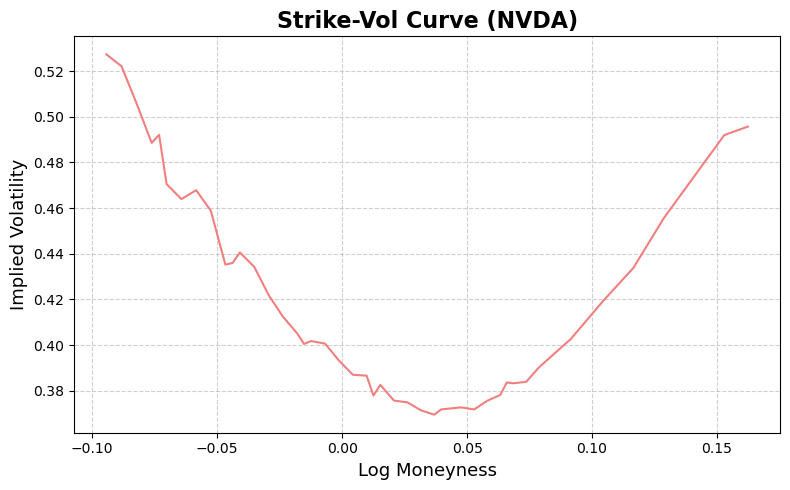

In [5]:
plt.figure(figsize=(8,5))

plt.plot(options['log_moneyness'], options['implied_vol_bs'], c='lightcoral')

plt.xlabel('Log Moneyness', fontsize=13)
plt.ylabel('Implied Volatility', fontsize=13)
plt.title(f'Strike-Vol Curve ({STOCK.upper()})', fontsize=16, fontweight='bold')

plt.grid(which='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

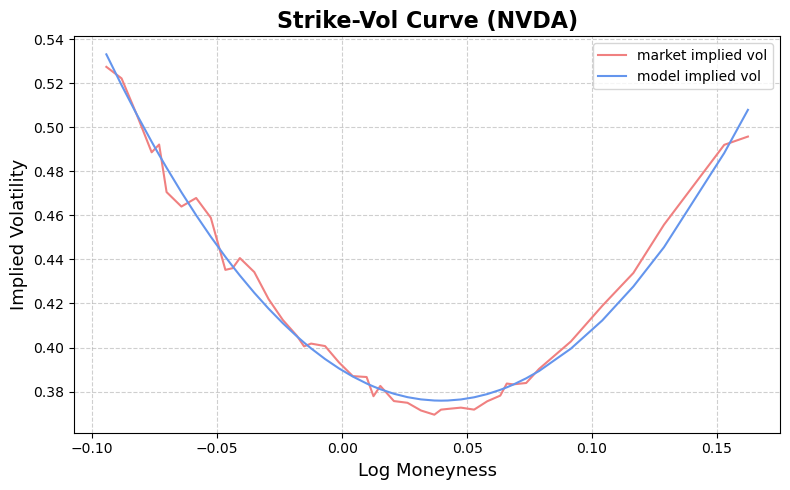

In [6]:
b = np.array(options['implied_vol_bs'])
x = np.array(options['log_moneyness'])
A = np.column_stack([np.ones_like(b),x,x**2])

params = np.linalg.solve(A.T@A,A.T@b)
options['implied_vol_est'] = A@params

plt.figure(figsize=(8,5))

plt.plot(options['log_moneyness'], options['implied_vol_bs'], c='lightcoral', label='market implied vol')
plt.plot(options['log_moneyness'], options['implied_vol_est'], c='cornflowerblue', label='model implied vol')

plt.xlabel('Log Moneyness', fontsize=13)
plt.ylabel('Implied Volatility', fontsize=13)
plt.title(f'Strike-Vol Curve ({STOCK.upper()})', fontsize=16, fontweight='bold')

plt.grid(which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
options.head()

,strike,mid_price,implied_vol_bs,log_moneyness,implied_vol_est
0,164.0,17.10,0.527371,-0.094367,0.533041
1,165.0,16.20,0.522141,-0.088288,0.519102
2,166.0,15.25,0.505797,-0.082246,0.505888
3,167.0,14.30,0.488595,-0.076240,0.493388
4,167.5,13.90,0.492121,-0.073250,0.487401


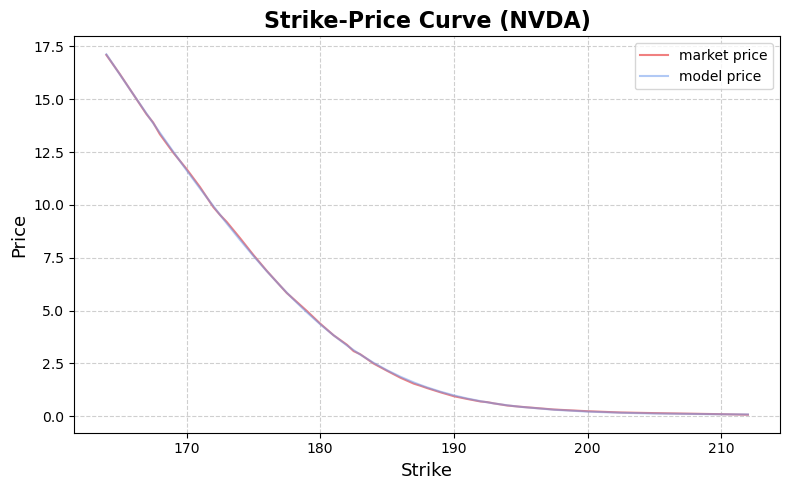

In [8]:
def get_model_price(row):
    return cbs(row['implied_vol_est'],row['strike'])

options['model_price'] = options.apply(get_model_price,axis=1)

plt.figure(figsize=(8,5))

plt.plot(options['strike'], options['mid_price'], c='lightcoral', label='market price')
plt.plot(options['strike'], options['model_price'], c='cornflowerblue', label='model price', alpha=0.5)

plt.xlabel('Strike', fontsize=13)
plt.ylabel('Price', fontsize=13)
plt.title(f'Strike-Price Curve ({STOCK.upper()})', fontsize=16, fontweight='bold')

plt.grid(which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
options.head()

,strike,mid_price,implied_vol_bs,log_moneyness,implied_vol_est,model_price
0,164.0,17.10,0.527371,-0.094367,0.533041,17.127515
1,165.0,16.20,0.522141,-0.088288,0.519102,16.184158
2,166.0,15.25,0.505797,-0.082246,0.505888,15.250489
3,167.0,14.30,0.488595,-0.076240,0.493388,14.327938
4,167.5,13.90,0.492121,-0.073250,0.487401,13.871334
